In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import seaborn as sns
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
import spc_os
RANDOM_SEED = 28101990

from pymc3 import DensityDist
from pymc3.math import switch,exp

import theano.tensor as T
import scipy.stats as st

In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/'

# Load data

In [3]:
df = pd.read_csv(f'{processed_data_dir}data.csv').drop('Unnamed: 0', axis=1)

Drop data that has nans

In [4]:
df = df.dropna()

In [5]:
df.membrane = df.membrane.replace(['BPM1', 'BPM2', 'BPM3', 'BPM4'],'BPM')

In [6]:
df.membrane = df.membrane.replace(['APM1', 'APM2', 'APM3', 'APM4'],'APM')

In [7]:
df.membrane=df.membrane.astype('category')

In [8]:
df['membrane_enc'] = df.membrane.cat.codes

## Visualize Data

In [9]:
df['tpore'].groupby(df['membrane']).describe()

,count,mean,std,min,25%,50%,75%,max
membrane,,,,,,,,
APM,240.0,3.289167,1.617545,1.0,2.175,3.00,4.10,9.4
BPM,120.0,6.510833,4.186408,1.5,3.775,4.85,8.55,21.1


In [10]:
min_val = df['tpore'].groupby(df['membrane']).min()

array([<AxesSubplot:title={'center':'APM'}>,
       <AxesSubplot:title={'center':'BPM'}>], dtype=object)

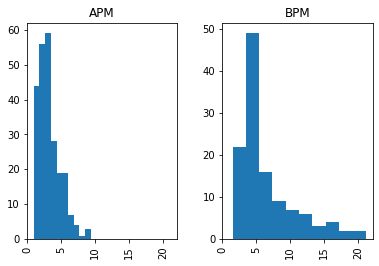

In [11]:
df['tpore'].hist(by=df['membrane'],sharex=True)

<AxesSubplot:>

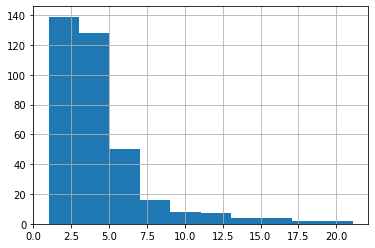

In [12]:
df['tpore'].hist()

# Non-Hierarchical Model

In [13]:
def logp_exp_lag(tau_0, tau):
    def logp_(t):
        #return T.log(T.switch(T.lt(t, tau_0), np.finfo(np.float64).tiny,T.exp( - (t - tau_0) / tau)/ tau ))
        return T.switch(T.lt(t, tau_0), - np.finfo(np.float64).max,  - (t - tau_0) / tau -  T.log( tau ))
    return  logp_

In [14]:
def exp_lag_cdf(t, tau_0, tau):
    if t < tau_0:
        cdf = 0.0
    elif t >= tau_0:
        cdf = 1-np.exp(-(t-tau_0)/tau)
    return cdf

In [15]:
exp_lag_cdf_vec = np.vectorize(exp_lag_cdf)

In [16]:
class my_pdf(st.rv_continuous):
    
    def _cdf(self,t,tau_0, tau):
        return exp_lag_cdf_vec(t, tau_0, tau)
my_cv = my_pdf(a=0, name='my_pdf')

In [17]:
from pymc3.distributions import draw_values, generate_samples
def random(point=None, size=None):
    # draw a numerical value for the parameters
    size = 1 if size is None else size
    tau_0_, tau_ = draw_values([tau_0, tau], point=point,size=size)
    
 
    return generate_samples(my_cv.rvs, tau=tau_, tau_0=tau_0_, size=size)

In [18]:
d = DensityDist.dist(logp_exp_lag).logp(0.5,1/3)

In [19]:
l = []
for i in range(1000):
    l.append(my_cv.rvs(tau_0=0.5,tau=1/3))

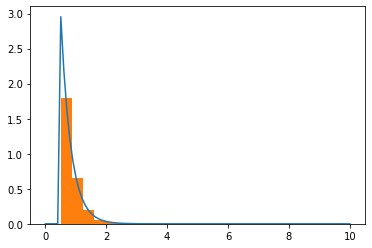

In [20]:
plt.plot(np.linspace(0,10,100),np.exp(d(np.linspace(0,10,100)).eval()))
_ = plt.hist(np.array(l), density=True)

## Visualize Priors

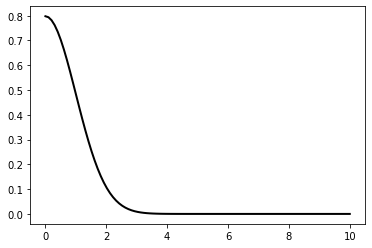

In [21]:
scale = 1
d = st.halfnorm(scale=scale)
x = np.linspace(0,10,100)
plt.plot(x, d.pdf(x), 'k-', lw=2)

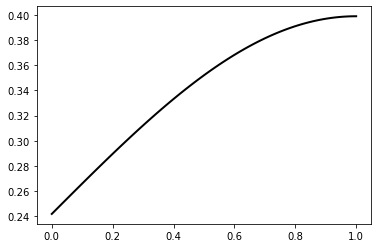

In [22]:
scale = 1
d = st.norm(scale=scale,loc=1)
x = np.linspace(0,1,100)
plt.plot(x, d.pdf(x), 'k-', lw=2)

## Run model

In [42]:
df.shape

(360, 31)

In [43]:
shape = df['membrane_enc'].unique().shape
with pm.Model() as my_model:
    tau = pm.HalfNormal('tau', sigma=1.,shape =shape)
    #tau = pm.Uniform('tau', 0., 5 )
    tau_0 = pm.TruncatedNormal('tau_0', mu = min_val, sigma = 1, lower = 0, upper = min_val, shape =shape)
    like = DensityDist('like', logp_exp_lag(tau_0[df['membrane_enc']],tau[df['membrane_enc']]), observed=df['tpore'], random=random, shape = (2,180))
    model_path = models_dir + f"kinetic_modelling_mix_same_membrane.nc"

In [44]:
with my_model:
    my_model_trace = pm.sample(4000, tune=3000,  random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(my_model_trace, var_names = ['like'],  random_seed=RANDOM_SEED)
    my_model_trace = az.from_pymc3(trace=my_model_trace, model=my_model, posterior_predictive=ppc)
    print('Done infering.')
    spc_os.remove(model_path)
    my_model_trace.to_netcdf(model_path)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_0, tau]


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 25 seconds.


Done infering.


## Analyze

### Point Summaries

Check that r_hat is approx 1 and that ess_mean is near to the number of steps.

In [25]:
df_summary = az.summary(my_model_trace)
with pd.option_context('display.max_rows', None):
    print(df_summary)

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
tau[0]    2.270  0.146   2.000    2.548      0.001    0.001   15480.0   
tau[1]    4.401  0.334   3.789    5.041      0.003    0.002   13733.0   
tau_0[0]  0.990  0.009   0.973    1.000      0.000    0.000   12685.0   
tau_0[1]  1.463  0.037   1.396    1.500      0.000    0.000   13687.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
tau[0]    15342.0   15583.0   11902.0    1.0  
tau[1]    13631.0   13813.0   11536.0    1.0  
tau_0[0]  12682.0    8791.0    5352.0    1.0  
tau_0[1]  13687.0   10937.0    6762.0    1.0  


### Plot Traces (Posteriors)

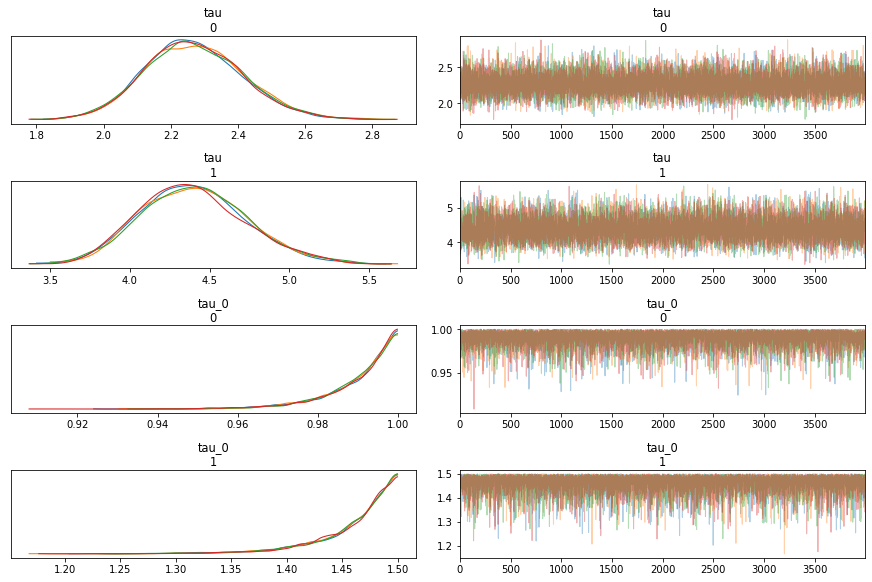

In [26]:
with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_trace(my_model_trace)

### Autocorrelations

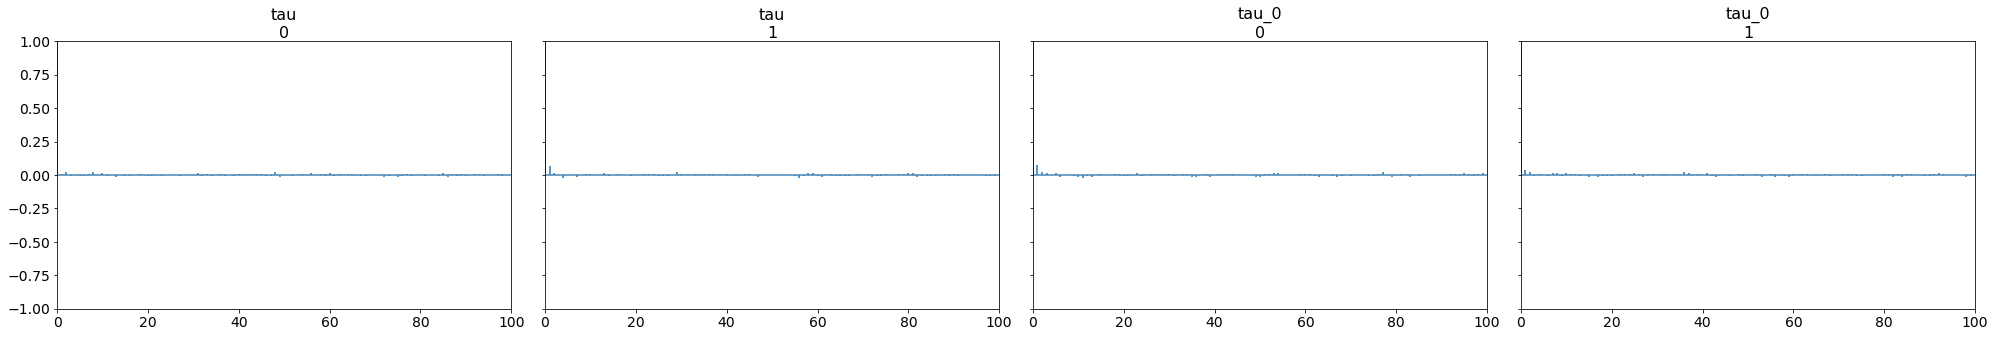

In [27]:
with az.rc_context(rc={'plot.max_subplots': None}):
    az.plot_autocorr(my_model_trace, combined=True)

### Posterior Predictive Test

In [48]:
my_model_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling/lib/python3.8/site-packages/arviz/plots/plot_utils.py:477: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (360) in plot_ppc, generating only 40 plots
  warnings.warn(
/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling/lib/python3.8/site-packages/arviz/stats/density_utils.py:610: UserWarning: Something failed: `x` is of length 1. Can't produce a KDE with only one data point.
  warnings.warn("Something failed: " + str(e))
/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling/lib/python3.8/site-packages/arviz/stats/density_utils.py:610: UserWarning: Something failed: `x` is of length 1. Can't produce a KDE with only one data point.
  warnings.warn("Something failed: " + str(e))


IndexError: index 1 is out of bounds for axis 0 with size 1

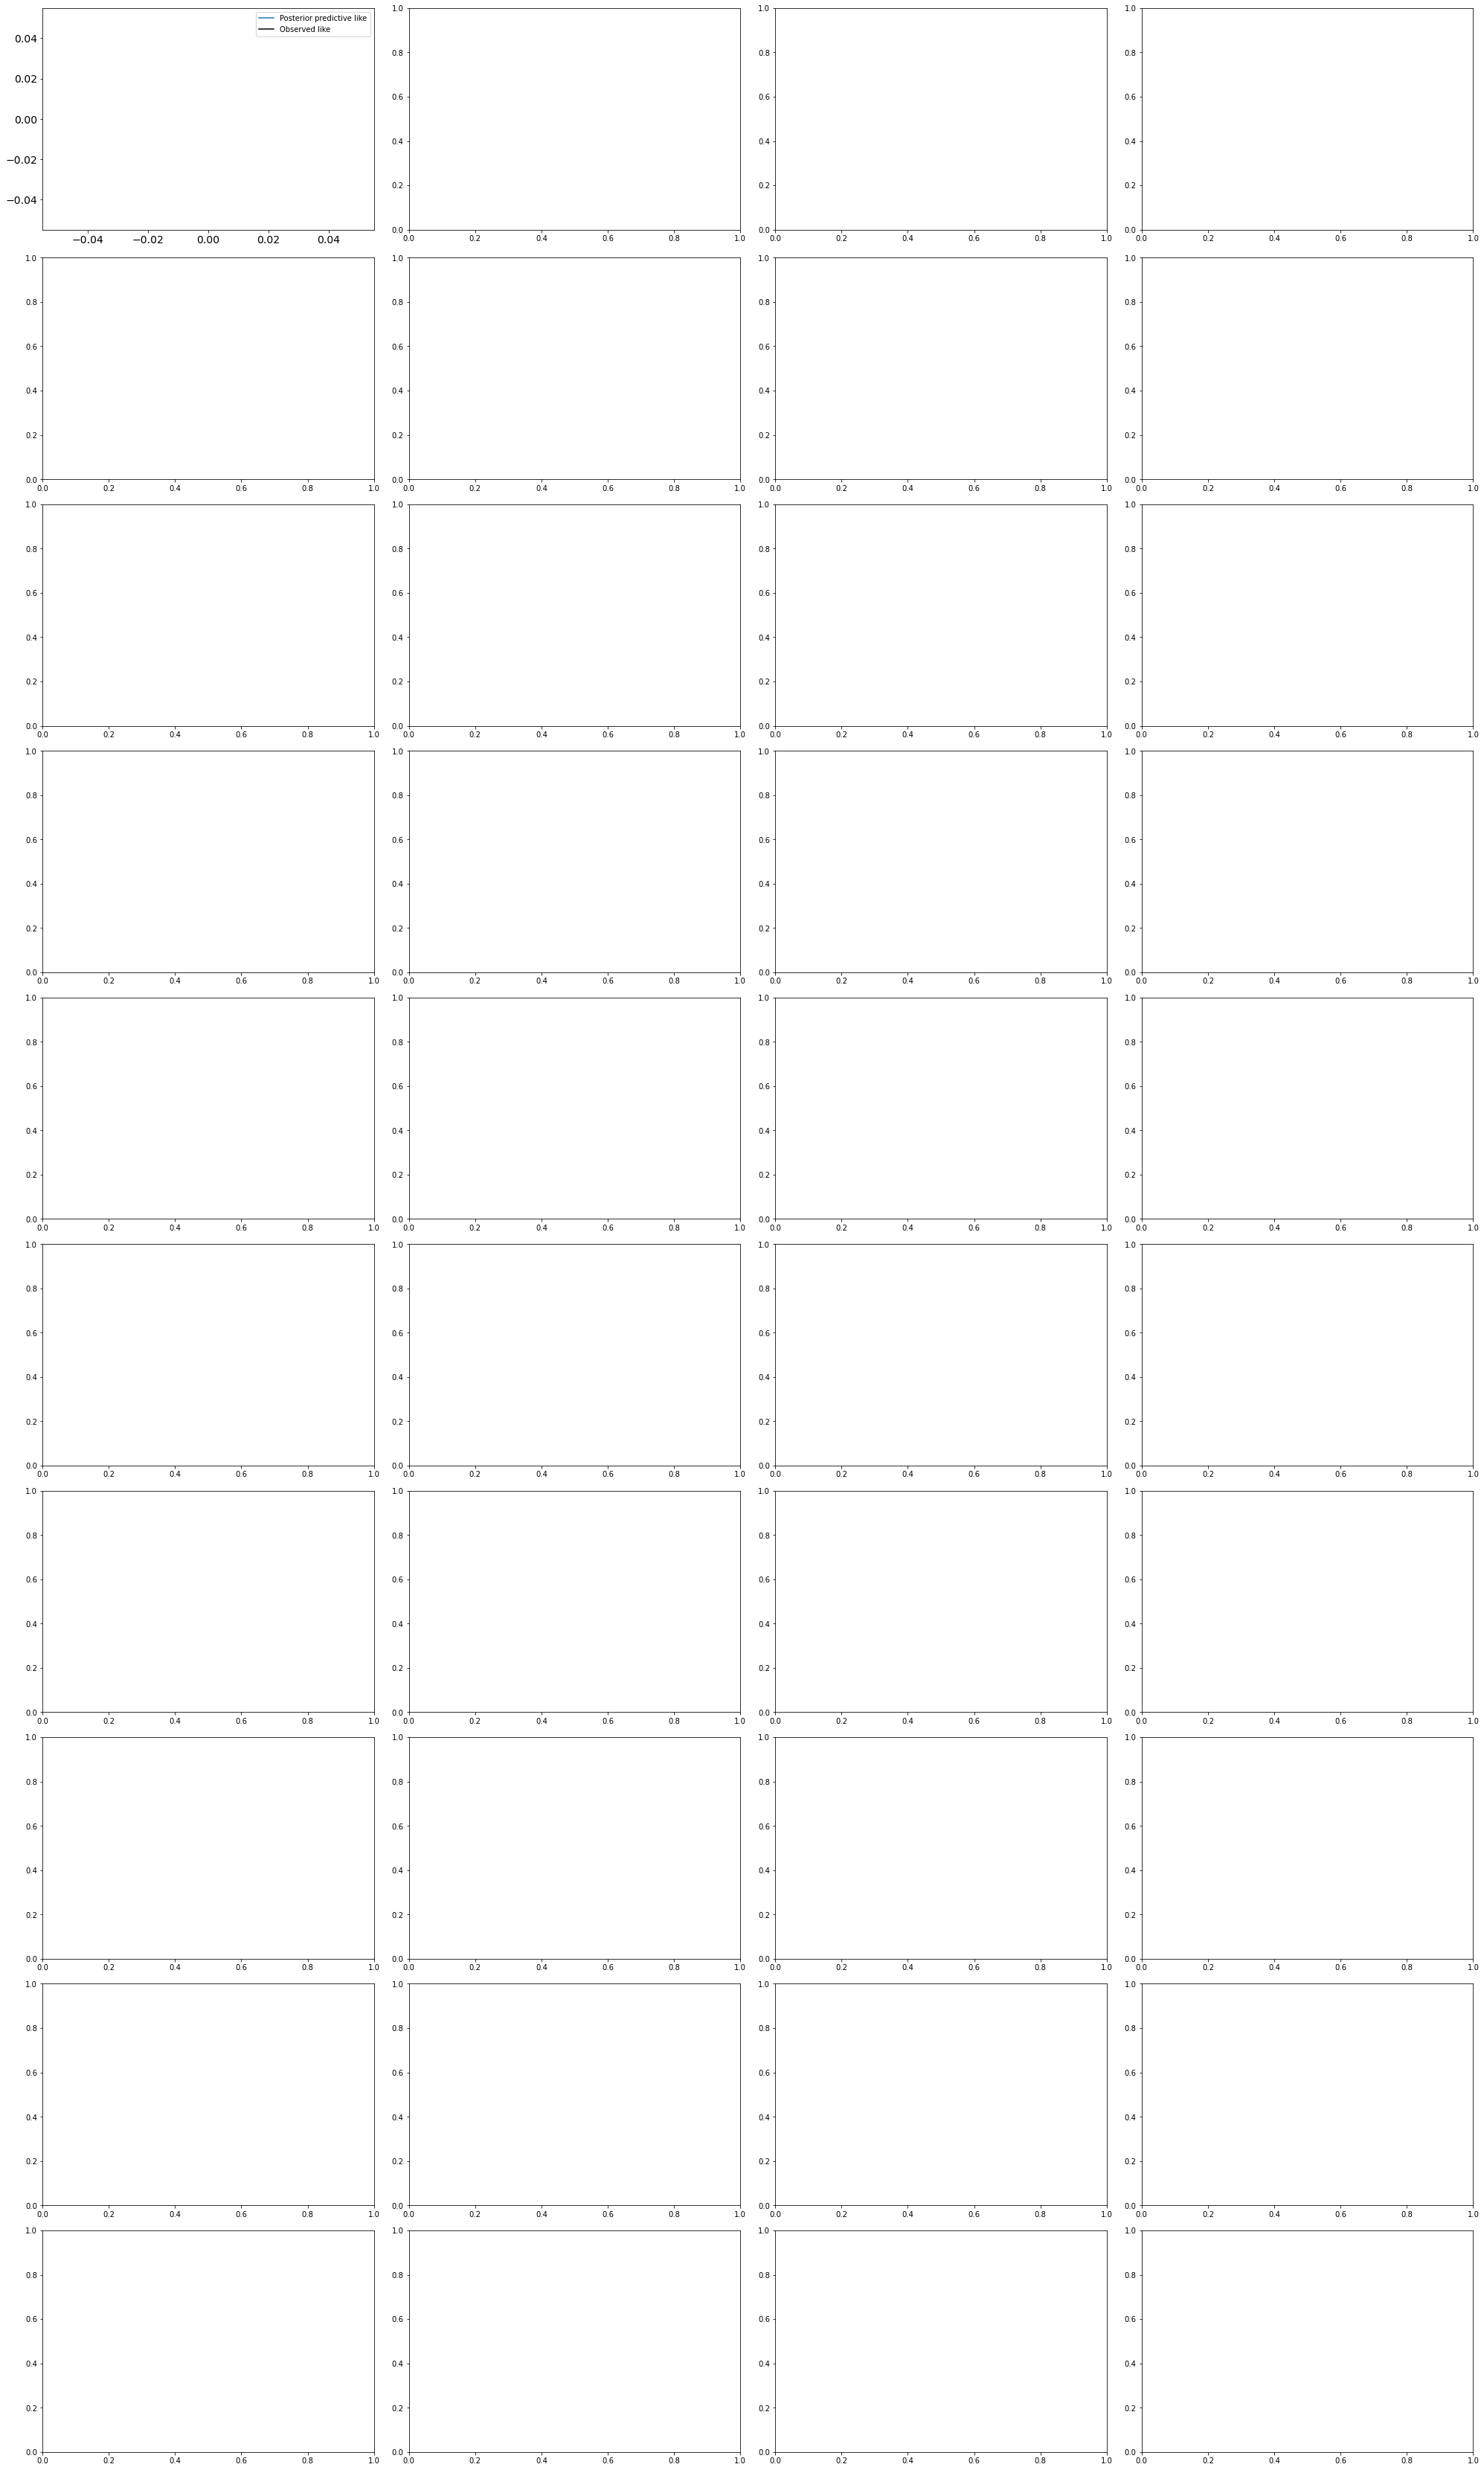

In [50]:
az.plot_ppc(my_model_trace, random_seed=RANDOM_SEED, var_names = ['like'], flatten = [1])

### Compare parameter

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

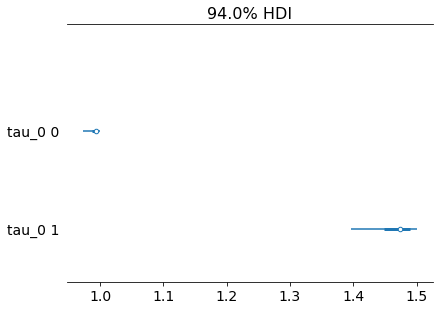

In [34]:
variable = 'tau_0'
az.plot_forest(my_model_trace,
               var_names=variable,
               combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

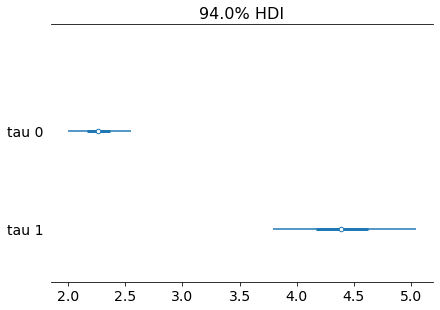

In [35]:
variable = 'tau'
az.plot_forest(my_model_trace,
               var_names=variable,
               combined=True)